# Exploratory preprocessing

In this notebook we explore how lightkurve can simplify the data preprocessing steps conducted in `astronet` and later mimicked in `exonet`.

First we need [lightkurve](https://docs.lightkurve.org/), probably version 1.2 or above.

In [1]:
import lightkurve as lk
import pandas as pd
from astropy.io import ascii
import numpy as np
import sys
import os

In [2]:
sys.path.append(os.path.abspath("../code/"))

We will need some custom utilities for fitting splines for flattening.  These capabilities are not yet in lightkurve.

In [3]:
from custom_utils import batch_flatten_collection

In [4]:
lk.__version__

'1.7.dev'

Now we need to understand what the preprocessing entails.  For that we can go to the [text of the original paper](http://adsabs.harvard.edu/abs/2018AJ....155...94S) in Section 3.2 titled "Light Curves":

> We then performed a few additional steps to prepare the light curves to be used as inputs to our neural network. For each TCE in the training set, we removed points corresponding to transits of any other confirmed planets in the system. Then, we "flattened" the light curve (that is, we removed low-frequency variability) by fitting a basis spline to the light curve and dividing it by the best-fit spline. To preserve transits, we removed the TCE's in-transit points while fitting the spline and linearly interpolated over those transits. We iteratively fit the spline, removed $3\sigma $ outliers, and refit the spline while interpolating over those outliers to prevent the spline from being "pulled" by discrepant points like cosmic-ray hits. This process is illustrated in Figure 3 of Vanderburg & Johnson (2014).

The next paragraph goes on to describe the method for getting the spline breakpoints.

**Section 3.3** then describes the *Input Representations*:

> We generate a **global view** of the light curve by choosing λ as a fraction of the TCE period. All light curves are binned to the same length, and each bin represents the same number of points, on average, across light curves. A disadvantage is that long-period TCEs may end up with very narrow transits that fall entirely within a small number of bins...

> We generate a **local view** of the transit by choosing λ as a fraction of the TCE duration. We consider k transit durations on either side of the event so that the transit occupies a fixed fraction of the resulting vector. This technique represents short- and long-period TCEs equally, but it only looks at part of the curve and therefore may miss important information, such as secondary eclipses 

The section concludes with a normalization procedure to make the transits all the same depth:

> ...we normalize all light curves to have median 0 and minimum value –1 so that all TCEs have a fixed transit depth.

First we'll need a mapping of target names (*e.g.* Kepler Input Catalog KIC IDs), to their respective, possibly multiple, Threshold Crossing Events.  That information is available in the DR24 products used by astronet and exonet, and soon to be updated to DR25.  For now we will [query the NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=q1_q17_dr24_tce) and save the output as an IPAC table in the `../data` directory.

In [5]:
! head -n 8 ../data/q1_q17_dr24_tce_2019.10.02_16.14.06.tbl

\ This file was produced by the NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu
\ Wed Oct  2 16:14:06 2019
\
\ COLUMN kepid:          KepID
\ COLUMN tce_plnt_num:   Planet Number
\ COLUMN tce_rogue_flag: Rogue Flag
\ COLUMN tce_delivname:  Delivery Name
\ COLUMN rowupdate:      Date of Last Update


In [6]:
tbldr24 = ascii.read('../data/q1_q17_dr24_tce_2019.10.02_16.14.06.tbl')

The most useful columns are:
1. `kepid`
2. `tce_plnt_num`
3. `tce_period` and `tce_period_err`
4. `tce_time0bk` and `tce_time0bk_err`
5. `tce_ror` and `tce_ror_err` (is this radius?)
6. `tce_duration` and `tce_duration_err`
7. `tce_depth` and `tce_depth_err`

In [7]:
dr24_tce = tbldr24[['kepid', 'tce_plnt_num', 'tce_period', 'tce_time0bk', 'tce_duration', 'tce_depth']].to_pandas()

We'll eventually need to iterate over the other TCEs (if any) in a given target, so it's useful to have a "total number of TCEs" columns readily availble:

In [8]:
tce_num_per_star = dr24_tce.groupby('kepid').tce_plnt_num.apply(lambda x:len(x.unique()))
dr24_tce= pd.merge(dr24_tce, 
                   tce_num_per_star.to_frame().rename(columns={'tce_plnt_num':'tot_plnts'}),
                    how='left',on='kepid')

Let's spot check one of these TCEs:

In [9]:
dr24_tce.tail(5)

,kepid,tce_plnt_num,tce_period,tce_time0bk,tce_duration,tce_depth,tot_plnts
20362,11906217,1,37.910200,162.459,3.139,102200.00,1
20363,11908559,1,0.716006,132.019,2.069,18.80,2
20364,11923562,2,0.739472,131.618,2.146,86.76,2
20365,11923819,1,33.159500,159.812,9.132,237900.00,2
20366,11923819,2,33.159200,137.774,11.940,119500.00,2


We will eventually want to add some metadata related to the **smoothness** of the lightcurve.  This metadata will be reused later for initializing Gaussian Process parameters.  These are both in days.

In [10]:
dr24_tce['peak_var_period'] = 0.0
dr24_tce['knot_spacing'] = 0.0

### Make a function for the global and local views.

In [11]:
kepid = 757450
tce_num = 1

In [12]:
#kepid = 2439243
#tce_num = 1

In [13]:
this_kepid_mask = (dr24_tce.kepid == kepid)
this_tce_mask = (dr24_tce.tce_plnt_num == tce_num)

this_tce_df = dr24_tce[this_kepid_mask & this_tce_mask]

In [14]:
this_tce_df

,kepid,tce_plnt_num,tce_period,tce_time0bk,tce_duration,tce_depth,tot_plnts,peak_var_period,knot_spacing
5,757450,1,8.88492,134.452,2.078,16310.0,1,0.0,0.0


In [15]:
def get_folded_tce_lightcurve(kepid, tce_num=1, dr24_tce=None):
    """Returns a FoldedLightCurve object for a kepler planet candidate
    
    Parameters
    ----------
    kepid : int
        The keplerid (aka KIC id) of the planet candidate as an integer
    
    tce_num : int
        The TCE number corresponding to potential multi-planet systems
        
    dr24_tce: float
        The entire DR24 TCE Catalog
    """
    kepid_mask = (dr24_tce.kepid == kepid)
    tce_df = dr24_tce[kepid_mask & (dr24_tce.tce_plnt_num == tce_num)]
    kepid_df = dr24_tce[this_kepid_mask]
    
    ## Get the target period, t0, and duration
    tce_period = tce_df.tce_period.values[0]
    tce_time0bk = tce_df.tce_time0bk.values[0]
    tce_duration = tce_df.tce_duration.values[0]
    
    # Download all available quarters and 
    #  filter overlapping sources that rarely occur in the KIC
    sr = lk.search_lightcurvefile('KIC {}'.format(kepid), mission='Kepler')
    match_indices = [i for i, v in enumerate(sr.target_name) if str(kepid) in v]
    lcfs = sr[match_indices].download_all()
    
    lcs = lcfs.PDCSAP_FLUX

    # Flatten all the quarters first using splines
    lcs_flattened_GP, trend_GP = batch_flatten_collection(lcs, kepid_df, method='GP', return_trend=True)
    lcs_flattened_sp, trend_sp = batch_flatten_collection(lcs, kepid_df, method='spline', return_trend=True)
    
    lcs_flattened = lcs_flattened_GP
    
    # Stitch all quarters together into one long lightcurve
    lc_raw = lcfs.PDCSAP_FLUX.stitch()
    lc_flat = lcs_flattened.stitch()
    
    # Phase fold
    n_bins_global = 2001
    lc_fold = lc_flat.fold(tce_period, t0=tce_time0bk)
    
    # Bin N_raw samples into a fixed number of N_bins and renormalize to [-1, 1]
    lc_global = lc_fold.bin(bins=n_bins_global, method='median').normalize() - 1
    lc_global /= -lc_global.flux.min()

    # Local view: keep from -4*duration : +4*duration
    fractional_duration = (tce_duration / 24.0) / tce_period
    
    # Override binning with a smoothing operation of oversized bins
    phase_mask = (lc_fold.phase > -4*fractional_duration) & (lc_fold.phase < 4.0*fractional_duration)
    lc_zoom = lc_fold[phase_mask]
    n_bins_local = 201
    lc_local = lc_zoom.bin(bins=n_bins_local, method='median')
    
    new_flux = lc_local.flux.copy()
    bin_size = np.median(np.diff(lc_local.time))
    for i, time_midpoint in enumerate(lc_local.time):
        time_mask = ( (lc_fold.time < (time_midpoint + 0.16*fractional_duration)) &
                      (lc_fold.time > (time_midpoint - 0.16*fractional_duration)) )
        new_flux[i] = np.median(lc_fold.flux[time_mask]) # The uncertainties will be overestimated
    
    lc_local.flux = new_flux
    lc_local = lc_local.normalize() - 1
    lc_local /= np.abs(lc_local.flux.min())
    
    return lc_raw, lc_local, lc_global, lc_flat, lcs, {'gp':trend_GP, 'sp':trend_sp}

In [16]:
lc_raw, lc_local, lc_global,lc_flat, lcs, extra = get_folded_tce_lightcurve(kepid, tce_num=1, dr24_tce=dr24_tce)

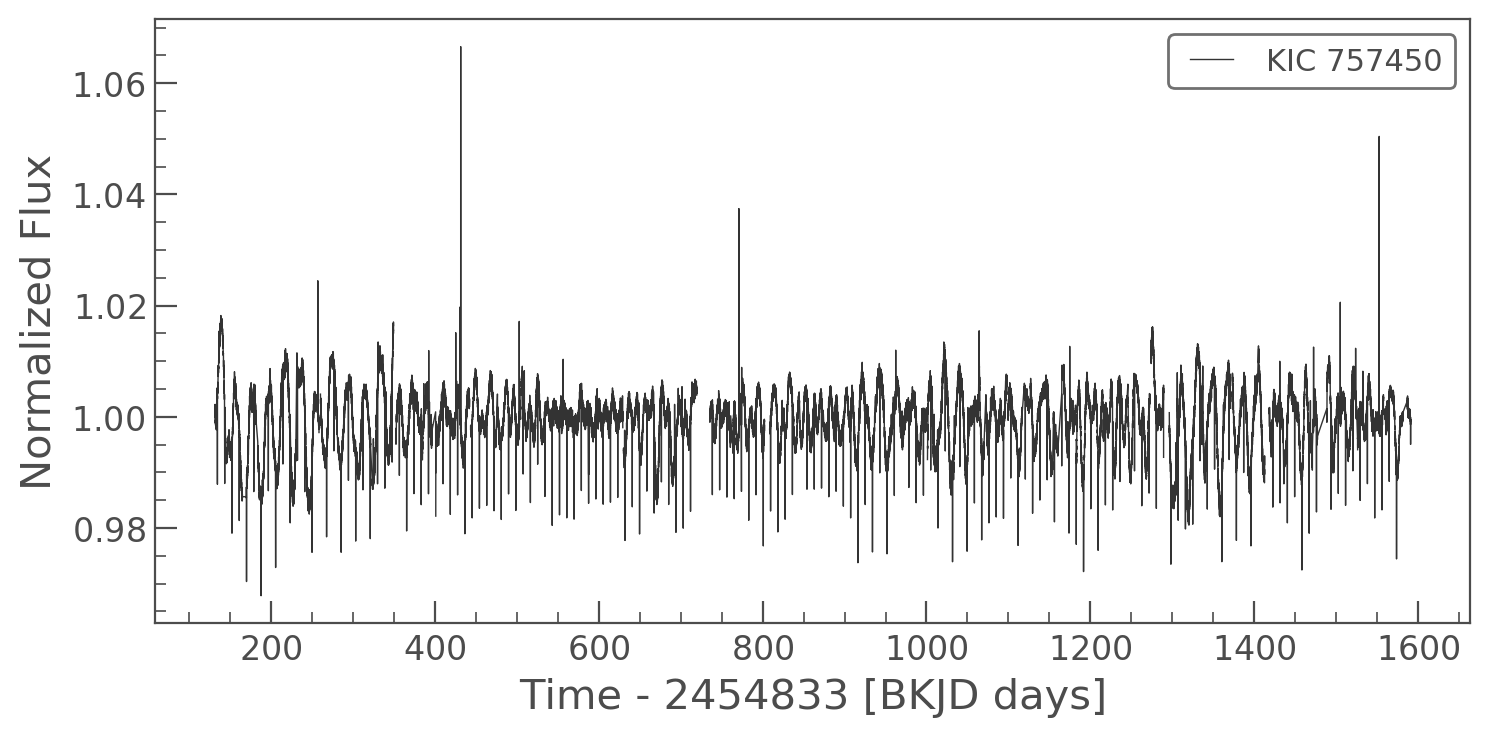

In [139]:
lc_raw.plot()

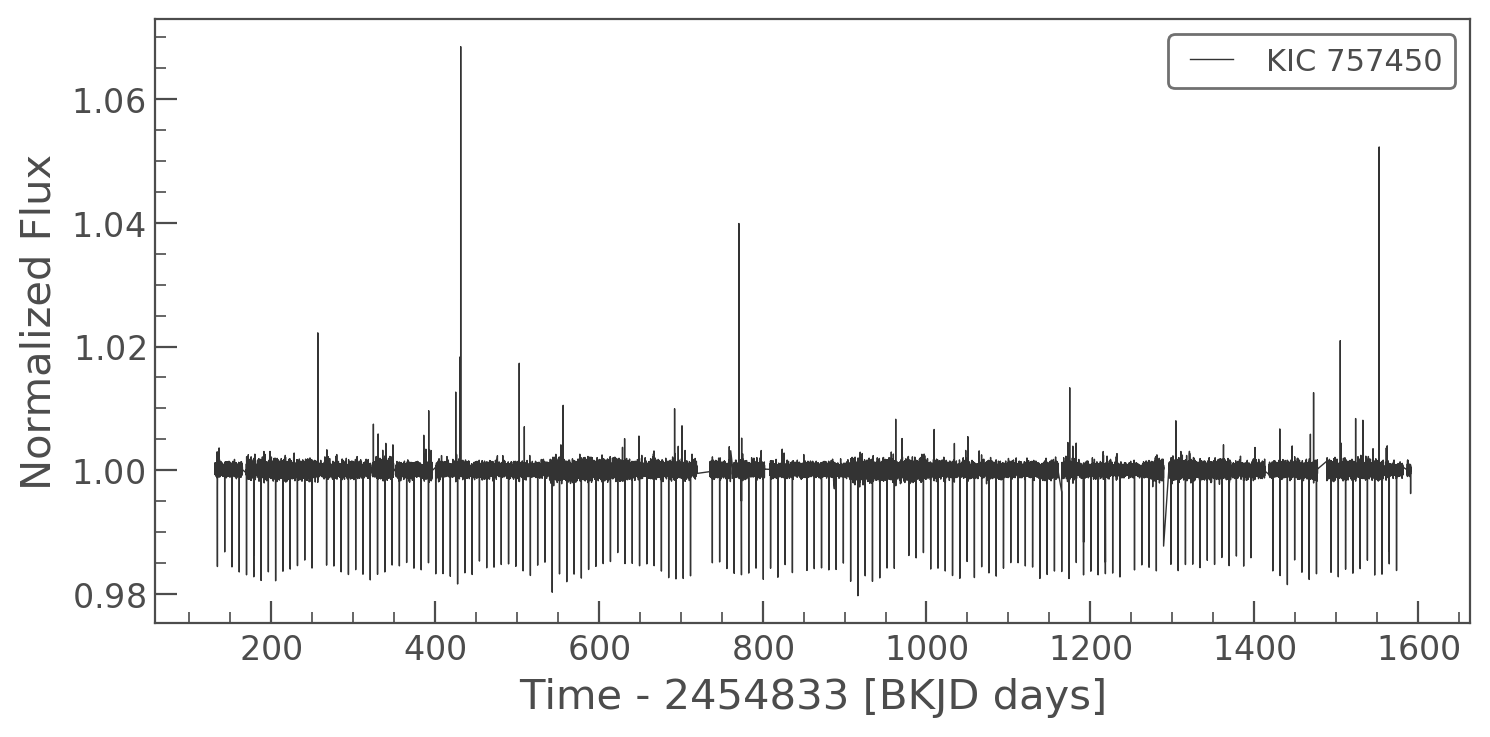

In [140]:
lc_flat.plot();

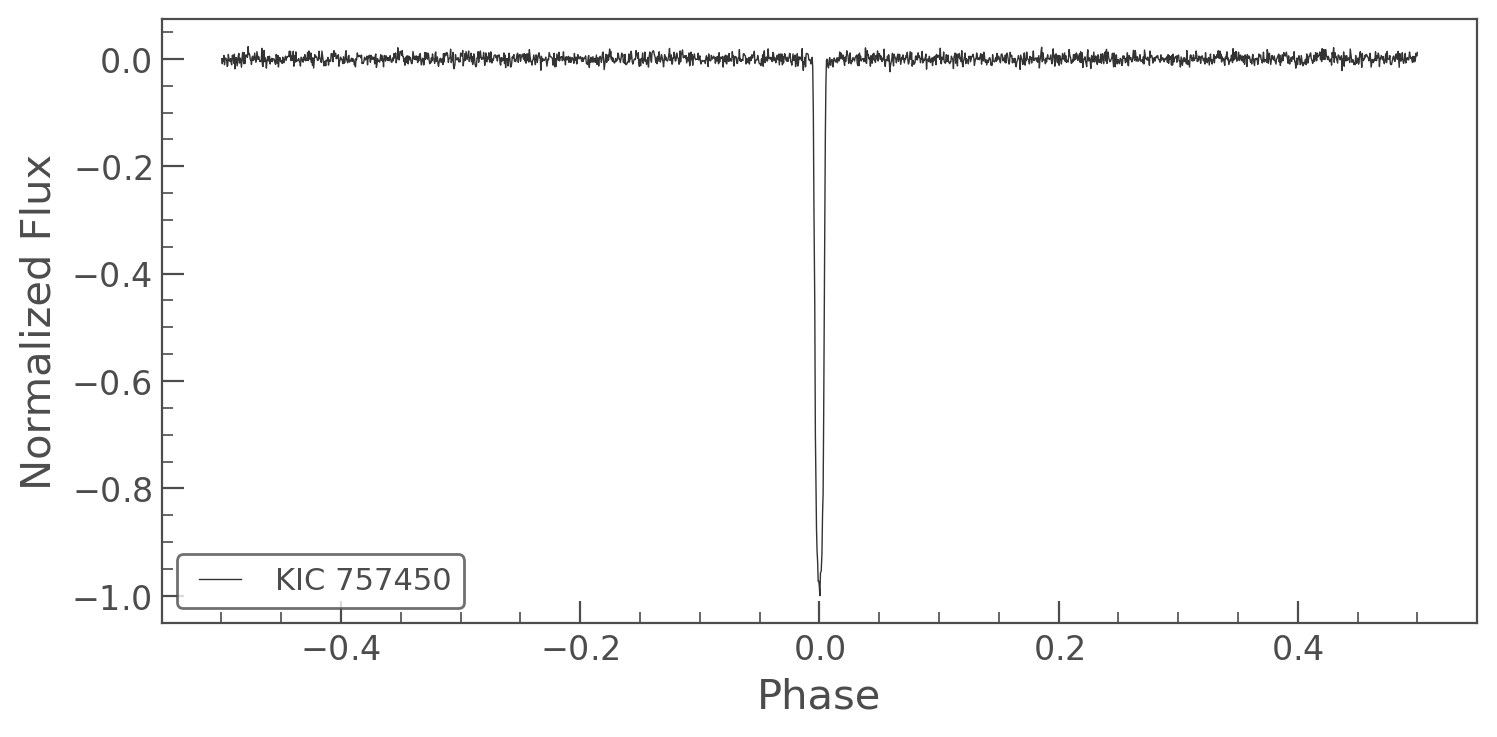

In [141]:
lc_global.plot();

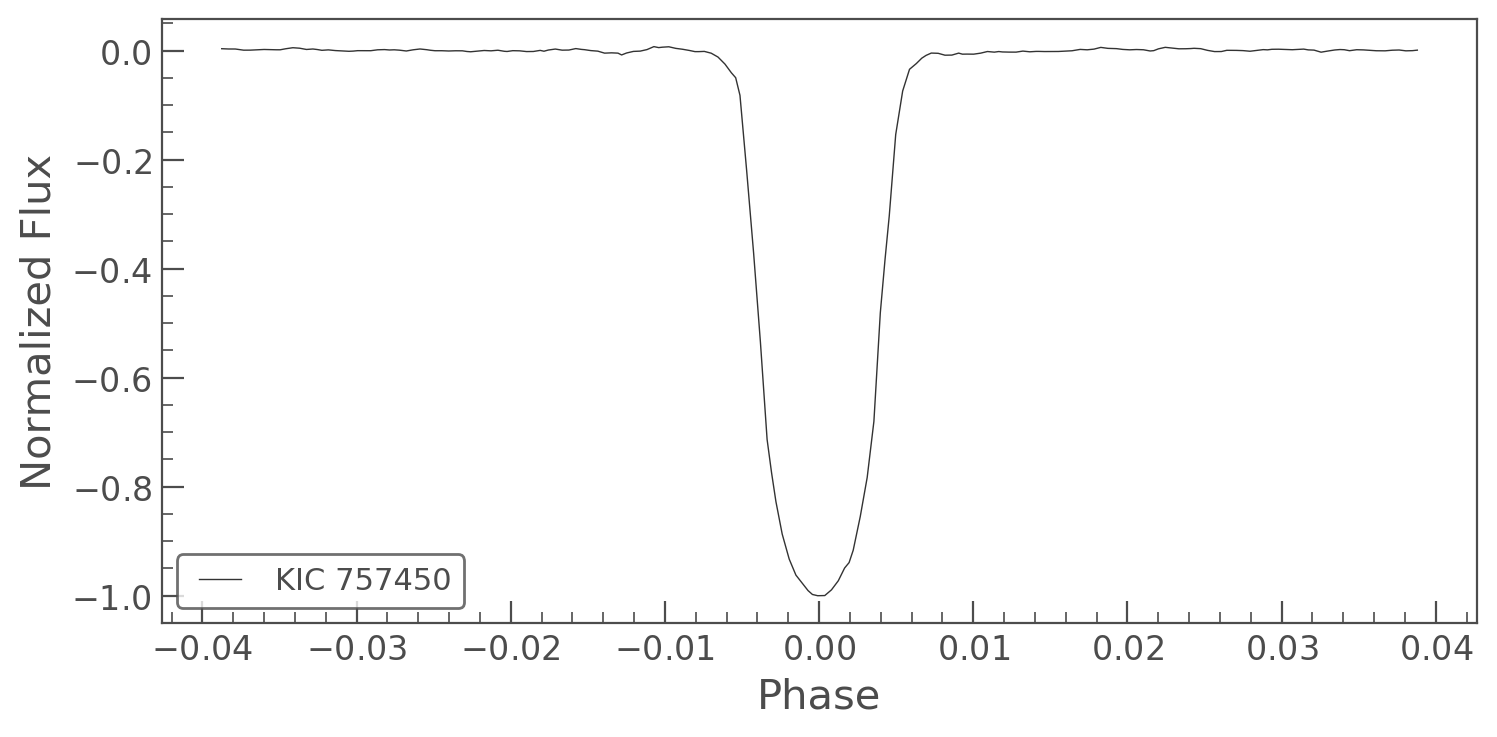

In [142]:
lc_local.plot();

TODOs:

1. ~~Mask the transits (from all TCEs in a given source)~~  
> Maybe change the code to accept a dataframe of the TCE list, which will simplify other aspects too.  

2. ~~Flattening strategy~~
> The high dynamic range of stellar variations makes it difficult to set a single flattening parameter, akin to the need to grid search over the spline knot distance in the Shallue & Vanderburg text.

3. ~~Adapt lightkurve `.bin()` method to accept `bins=` parameter.~~

4. Demonstrate centroid views
> The centroid views will become automatic once PR #604 is merged, currently under review.

5. ~~Demo GP flattening~~
> GP flattening can outperform (or underperform!) splines.  Let's do both and compare the performance of each.

6. Scale out to all TCEs for all KOIs